# Homework - ExploringFunction Approximation with a Neural Net

In this notebook, you will explore fitting different neural network version to the example introduced in class.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable
import matplotlib.pyplot as plt

Defining the non-linear function and noisy version.

In [2]:
# True functions
def func_GT(x):
    if x < 0.:
        f = 5.0 + np.sin(x) + np.sin(2.*x) + np.sin(3.*x) + np.sin(4.*x)
    else:
        f = np.cos(10.*x)
    return f

# Function Definitions
def func(x):
    f = func_GT(x)
    f = f + np.random.normal(0,0.1)
    return f

Defining and visualizing the noise-free test set.

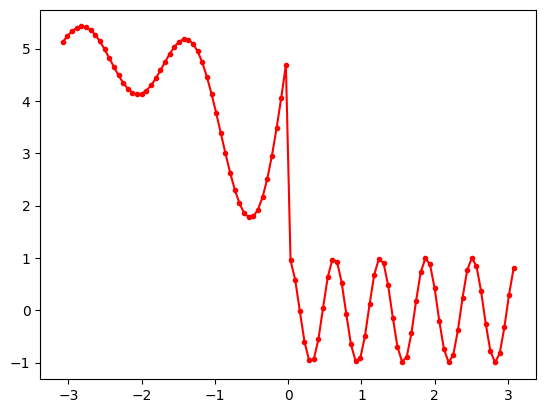

In [3]:
x_test = np.linspace(-np.pi,np.pi,100)
x_test = x_test[1:-1]
y_test = np.array([func_GT(z) for z in x_test])

# Formatting the set
x_test = x_test.reshape(-1,1)
y_test = y_test.reshape(-1,1)

plt.plot(x_test,y_test,'r.-')
plt.show()

## Training a Neural Network with Noisy Data

We begin by defining the same network architecture used in lecture.

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_layers, num_neurons, output_dim):
        super(Net, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module("lin_layer_0", nn.Linear(input_dim,num_neurons))
        self.net.add_module("tanh_layer_0", nn.Tanh())

        for num in range(1, hidden_layers+1):
            self.net.add_module("lin_layer_%d" %(num), nn.Linear(num_neurons, num_neurons))
            self.net.add_module("tanh_layer_%d", nn.Tanh())

        self.net.add_module("lin_layer_output", nn.Linear(num_neurons, output_dim))

    def forward(self, x):
        return self.net(x)

# Specifying hyper-parameters
input_dim = 1
output_dim = 1
hidden_layers = 2
num_neurons = 40

# Creating an instance of the neural net together with the optimizer and loss
net = Net(input_dim, hidden_layers, num_neurons, output_dim)
optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-03)
loss_func = torch.nn.MSELoss()

summary(net,(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]              80
              Tanh-2                   [-1, 40]               0
            Linear-3                   [-1, 40]           1,640
              Tanh-4                   [-1, 40]               0
            Linear-5                   [-1, 40]           1,640
            Linear-6                    [-1, 1]              41
Total params: 3,401
Trainable params: 3,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


Defining the training set.

In [5]:
# Specifying the number of training points
N_train = 100

# Defining the training set
x_train = np.array(np.linspace(-np.pi,np.pi,N_train))
y_train = np.array([func(z) for z in x_train])

# Formatting the set
x_train = x_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)

Training the network.

In [6]:
# Specifying the number of training iterations
N_iter = 50000

x_train_torch = torch.from_numpy(x_train).float()
y_train_torch = torch.from_numpy(y_train).float()

y_pred_list = []
iter_list = []

for n in range(N_iter):
  pred = net(x_train_torch)
  loss = loss_func(pred,y_train_torch)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if n%1000 == 0:
    y_pred = pred.data.numpy()
    y_pred_list.append(y_pred)
    iter_list.append(n)
    print('Steps: %d, loss: %.3e'%(n, loss))

Steps: 0, loss: 9.120e+00
Steps: 1000, loss: 3.163e-01
Steps: 2000, loss: 2.151e-01
Steps: 3000, loss: 1.897e-01
Steps: 4000, loss: 1.759e-01
Steps: 5000, loss: 1.667e-01
Steps: 6000, loss: 1.582e-01
Steps: 7000, loss: 1.352e-01
Steps: 8000, loss: 1.204e-01
Steps: 9000, loss: 1.180e-01
Steps: 10000, loss: 1.173e-01
Steps: 11000, loss: 1.169e-01
Steps: 12000, loss: 1.165e-01
Steps: 13000, loss: 1.162e-01
Steps: 14000, loss: 1.159e-01
Steps: 15000, loss: 1.174e-01
Steps: 16000, loss: 1.155e-01
Steps: 17000, loss: 1.152e-01
Steps: 18000, loss: 1.249e-01
Steps: 19000, loss: 1.145e-01
Steps: 20000, loss: 1.191e-01
Steps: 21000, loss: 1.135e-01
Steps: 22000, loss: 1.126e-01
Steps: 23000, loss: 1.109e-01
Steps: 24000, loss: 1.071e-01
Steps: 25000, loss: 9.956e-02
Steps: 26000, loss: 7.341e-02
Steps: 27000, loss: 5.643e-02
Steps: 28000, loss: 4.332e-02
Steps: 29000, loss: 3.204e-02
Steps: 30000, loss: 1.591e-02
Steps: 31000, loss: 1.774e-02
Steps: 32000, loss: 1.140e-02
Steps: 33000, loss: 1.2

MSE = 0.005


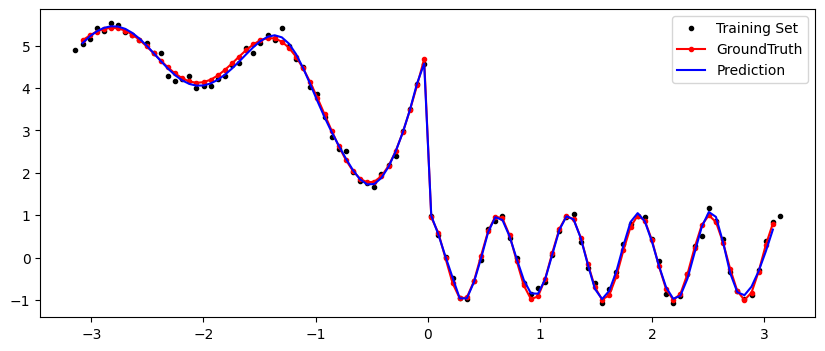

In [7]:
fig = plt.figure(figsize=(10,4))

x_test_torch = torch.from_numpy(x_test).float()
y_test_torch = torch.from_numpy(y_test).float()
y_pred_torch = net(x_test_torch)
y_pred = y_pred_torch.data.numpy()

loss = loss_func(y_test_torch,y_pred_torch)
print('MSE = %5.3f'%(loss.data.numpy()))

plt.plot(x_train,y_train,'k.',label='Training Set')
plt.plot(x_test,y_test,'r.-',label='GroundTruth')
plt.plot(x_test,y_pred,'b-',label='Prediction')
plt.legend()
plt.show()

## Task 1 - Computing Average Performance for Tanh Network

Run the previous code ten times, and report the mean and standard deviation of the test MSE. Make sure that you randomly initialize the network weights every time, and generate new data every time as well.

In [4]:
mse_list = []

### YOUR CODE HERE

In [5]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_layers, num_neurons, output_dim):
        super(Net, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module("lin_layer_0", nn.Linear(input_dim,num_neurons))
        self.net.add_module("tanh_layer_0", nn.Tanh())

        for num in range(1, hidden_layers+1):
            self.net.add_module("lin_layer_%d" %(num), nn.Linear(num_neurons, num_neurons))
            self.net.add_module("tanh_layer_%d", nn.Tanh())

        self.net.add_module("lin_layer_output", nn.Linear(num_neurons, output_dim))

    def forward(self, x):
        return self.net(x)

In [6]:
# Specifying hyper-parameters
input_dim = 1
output_dim = 1
hidden_layers = 2
num_neurons = 40
N_train = 100
N_iter = 50000

# Defining the training set
x_train = np.array(np.linspace(-np.pi, np.pi, N_train))
y_train = np.array([func(z) for z in x_train])

# Formatting the set
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

# Converting to torch tensors
x_train_torch = torch.from_numpy(x_train).float()
y_train_torch = torch.from_numpy(y_train).float()

In [7]:
for run in range(10):
    print(f"Run {run+1}")

    # Creating a new network instance and optimizer for each run
    net = Net(input_dim, hidden_layers, num_neurons, output_dim)
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-03)
    loss_func = torch.nn.MSELoss()

    y_pred_list = []
    iter_list = []

    # Training the model
    for n in range(N_iter):
        pred = net(x_train_torch)
        loss = loss_func(pred, y_train_torch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if n % 1000 == 0:
            y_pred = pred.data.numpy()
            y_pred_list.append(y_pred)
            iter_list.append(n)
            print('Steps: %d, loss: %.3e' % (n, loss.item()))

    # Storing the final loss (MSE) for this run
    mse_list.append(loss.item())
    print(f"Final MSE for run {run+1}: {loss.item():.3e}\n")

Run 1
Steps: 0, loss: 9.061e+00
Steps: 1000, loss: 6.465e-01
Steps: 2000, loss: 2.677e-01
Steps: 3000, loss: 2.459e-01
Steps: 4000, loss: 2.234e-01
Steps: 5000, loss: 2.149e-01
Steps: 6000, loss: 1.887e-01
Steps: 7000, loss: 1.786e-01
Steps: 8000, loss: 1.747e-01
Steps: 9000, loss: 1.551e-01
Steps: 10000, loss: 1.334e-01
Steps: 11000, loss: 1.240e-01
Steps: 12000, loss: 1.216e-01
Steps: 13000, loss: 1.207e-01
Steps: 14000, loss: 1.202e-01
Steps: 15000, loss: 1.198e-01
Steps: 16000, loss: 1.194e-01
Steps: 17000, loss: 1.191e-01
Steps: 18000, loss: 1.203e-01
Steps: 19000, loss: 1.185e-01
Steps: 20000, loss: 1.182e-01
Steps: 21000, loss: 1.179e-01
Steps: 22000, loss: 1.175e-01
Steps: 23000, loss: 1.172e-01
Steps: 24000, loss: 1.169e-01
Steps: 25000, loss: 1.167e-01
Steps: 26000, loss: 1.164e-01
Steps: 27000, loss: 1.160e-01
Steps: 28000, loss: 1.156e-01
Steps: 29000, loss: 1.149e-01
Steps: 30000, loss: 1.140e-01
Steps: 31000, loss: 1.131e-01
Steps: 32000, loss: 1.115e-01
Steps: 33000, los

Reporting the mean and standard deviation of the errors.

In [8]:
print('Mean MSE %5.3f | Std MSE %5.3f'%(np.mean(mse_list),np.std(mse_list)))

Mean MSE 0.048 | Std MSE 0.051


## Task 2 - Defining a ReLU Network

Define a new network with the same architecture but use ReLU activations instead of Tanh. Compute the MSE and plot the predictions for the single run.

In [ ]:
### YOUR CODE HERE

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_layers, num_neurons, output_dim):
        super(Net, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module("lin_layer_0", nn.Linear(input_dim,num_neurons))
        self.net.add_module("relu_layer_0", nn.ReLU())

        for num in range(1, hidden_layers+1):
            self.net.add_module("lin_layer_%d" %(num), nn.Linear(num_neurons, num_neurons))
            self.net.add_module("relu_layer_%d", nn.ReLU())

        self.net.add_module("lin_layer_output", nn.Linear(num_neurons, output_dim))

    def forward(self, x):
        return self.net(x)

# Specifying hyper-parameters
input_dim = 1
output_dim = 1
hidden_layers = 2
num_neurons = 40

# Creating an instance of the neural net together with the optimizer and loss
net = Net(input_dim, hidden_layers, num_neurons, output_dim)
optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-03)
loss_func = torch.nn.MSELoss()

summary(net,(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]              80
              ReLU-2                   [-1, 40]               0
            Linear-3                   [-1, 40]           1,640
              ReLU-4                   [-1, 40]               0
            Linear-5                   [-1, 40]           1,640
            Linear-6                    [-1, 1]              41
Total params: 3,401
Trainable params: 3,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [5]:
# Specifying the number of training points
N_train = 100

# Defining the training set
x_train = np.array(np.linspace(-np.pi,np.pi,N_train))
y_train = np.array([func(z) for z in x_train])

# Formatting the set
x_train = x_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [6]:
# Specifying the number of training iterations
N_iter = 50000

x_train_torch = torch.from_numpy(x_train).float()
y_train_torch = torch.from_numpy(y_train).float()

y_pred_list = []
iter_list = []

for n in range(N_iter):
  pred = net(x_train_torch)
  loss = loss_func(pred,y_train_torch)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if n%1000 == 0:
    y_pred = pred.data.numpy()
    y_pred_list.append(y_pred)
    iter_list.append(n)
    print('Steps: %d, loss: %.3e'%(n, loss))

Steps: 0, loss: 9.991e+00
Steps: 1000, loss: 2.142e-01
Steps: 2000, loss: 1.685e-01
Steps: 3000, loss: 1.445e-01
Steps: 4000, loss: 1.383e-01
Steps: 5000, loss: 1.362e-01
Steps: 6000, loss: 1.353e-01
Steps: 7000, loss: 1.348e-01
Steps: 8000, loss: 1.345e-01
Steps: 9000, loss: 1.343e-01
Steps: 10000, loss: 1.341e-01
Steps: 11000, loss: 1.340e-01
Steps: 12000, loss: 1.339e-01
Steps: 13000, loss: 1.338e-01
Steps: 14000, loss: 1.337e-01
Steps: 15000, loss: 1.342e-01
Steps: 16000, loss: 1.422e-01
Steps: 17000, loss: 1.335e-01
Steps: 18000, loss: 1.335e-01
Steps: 19000, loss: 1.334e-01
Steps: 20000, loss: 1.334e-01
Steps: 21000, loss: 1.334e-01
Steps: 22000, loss: 1.333e-01
Steps: 23000, loss: 1.332e-01
Steps: 24000, loss: 1.331e-01
Steps: 25000, loss: 1.331e-01
Steps: 26000, loss: 1.331e-01
Steps: 27000, loss: 1.331e-01
Steps: 28000, loss: 1.331e-01
Steps: 29000, loss: 1.330e-01
Steps: 30000, loss: 1.331e-01
Steps: 31000, loss: 1.258e-01
Steps: 32000, loss: 1.250e-01
Steps: 33000, loss: 1.2

MSE = 0.076


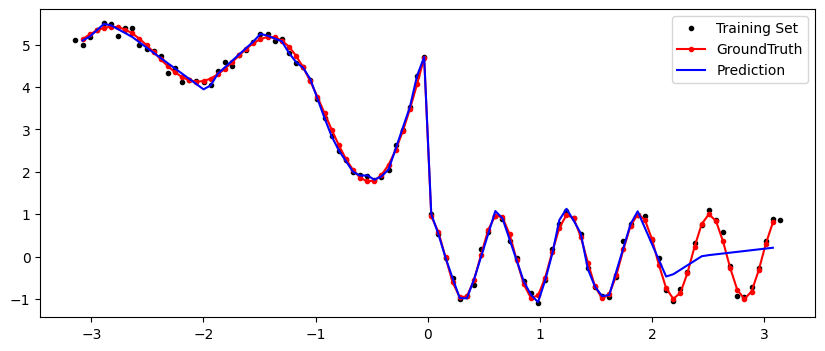

In [7]:
fig = plt.figure(figsize=(10,4))

x_test_torch = torch.from_numpy(x_test).float()
y_test_torch = torch.from_numpy(y_test).float()
y_pred_torch = net(x_test_torch)
y_pred = y_pred_torch.data.numpy()

loss = loss_func(y_test_torch,y_pred_torch)
print('MSE = %5.3f'%(loss.data.numpy()))

plt.plot(x_train,y_train,'k.',label='Training Set')
plt.plot(x_test,y_test,'r.-',label='GroundTruth')
plt.plot(x_test,y_pred,'b-',label='Prediction')
plt.legend()
plt.show()

## Task 3 - Computing Average Performance of ReLU Network

Run the code for the ReLU network ten times, and report the mean and standard deviation of the test MSE. Make sure that you randomly initialize the network weights every time, and generate new data every time as well.

In [8]:
mse_list = []

### YOUR CODE HERE

In [9]:
# Neural network with ReLU activations (as you provided)
class Net(nn.Module):
    def __init__(self, input_dim, hidden_layers, num_neurons, output_dim):
        super(Net, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module("lin_layer_0", nn.Linear(input_dim, num_neurons))
        self.net.add_module("relu_layer_0", nn.ReLU())

        for num in range(1, hidden_layers + 1):
            self.net.add_module("lin_layer_%d" % num, nn.Linear(num_neurons, num_neurons))
            self.net.add_module("relu_layer_%d", nn.ReLU())

        self.net.add_module("lin_layer_output", nn.Linear(num_neurons, output_dim))

    def forward(self, x):
        return self.net(x)

In [10]:
# Specifying hyper-parameters
input_dim = 1
output_dim = 1
hidden_layers = 2
num_neurons = 40
N_train = 100
N_iter = 50000

# Defining the training set
x_train = np.array(np.linspace(-np.pi, np.pi, N_train))
y_train = np.array([func(z) for z in x_train])

# Formatting the set
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

# Converting to torch tensors
x_train_torch = torch.from_numpy(x_train).float()
y_train_torch = torch.from_numpy(y_train).float()

In [11]:
for run in range(10):
    print(f"Run {run+1}")

    # Creating a new network instance and optimizer for each run
    net = Net(input_dim, hidden_layers, num_neurons, output_dim)
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-03)
    loss_func = nn.MSELoss()

    y_pred_list = []
    iter_list = []

    # Training the model
    for n in range(N_iter):
        pred = net(x_train_torch)
        loss = loss_func(pred, y_train_torch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if n % 1000 == 0:
            y_pred = pred.data.numpy()
            y_pred_list.append(y_pred)
            iter_list.append(n)
            print('Steps: %d, loss: %.3e' % (n, loss.item()))

    # Storing the final loss (MSE) for this run
    mse_list.append(loss.item())
    print(f"Final MSE for run {run+1}: {loss.item():.3e}\n")

Run 1
Steps: 0, loss: 1.106e+01
Steps: 1000, loss: 1.960e-01
Steps: 2000, loss: 1.004e-01
Steps: 3000, loss: 8.537e-02
Steps: 4000, loss: 8.267e-02
Steps: 5000, loss: 8.133e-02
Steps: 6000, loss: 8.147e-02
Steps: 7000, loss: 7.991e-02
Steps: 8000, loss: 8.013e-02
Steps: 9000, loss: 7.738e-02
Steps: 10000, loss: 7.686e-02
Steps: 11000, loss: 7.671e-02
Steps: 12000, loss: 7.721e-02
Steps: 13000, loss: 7.626e-02
Steps: 14000, loss: 7.631e-02
Steps: 15000, loss: 7.741e-02
Steps: 16000, loss: 7.827e-02
Steps: 17000, loss: 7.569e-02
Steps: 18000, loss: 7.559e-02
Steps: 19000, loss: 7.550e-02
Steps: 20000, loss: 7.544e-02
Steps: 21000, loss: 7.624e-02
Steps: 22000, loss: 7.595e-02
Steps: 23000, loss: 7.800e-02
Steps: 24000, loss: 7.531e-02
Steps: 25000, loss: 7.534e-02
Steps: 26000, loss: 7.599e-02
Steps: 27000, loss: 7.515e-02
Steps: 28000, loss: 7.505e-02
Steps: 29000, loss: 7.526e-02
Steps: 30000, loss: 7.492e-02
Steps: 31000, loss: 7.552e-02
Steps: 32000, loss: 7.670e-02
Steps: 33000, los

In [12]:
print('Mean MSE %5.3f | Std MSE %5.3f'%(np.mean(mse_list),np.std(mse_list)))

Mean MSE 0.060 | Std MSE 0.049


## Task 4 - Exploring Random Sampling

Use the original Tanh network but generate the training data using a random uniform distribution. Compute the MSE and plot the predictions for the single run.

In [ ]:
### YOUR CODE HERE

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_layers, num_neurons, output_dim):
        super(Net, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module("lin_layer_0", nn.Linear(input_dim,num_neurons))
        self.net.add_module("tanh_layer_0", nn.Tanh())

        for num in range(1, hidden_layers+1):
            self.net.add_module("lin_layer_%d" %(num), nn.Linear(num_neurons, num_neurons))
            self.net.add_module("tanh_layer_%d", nn.Tanh())

        self.net.add_module("lin_layer_output", nn.Linear(num_neurons, output_dim))

    def forward(self, x):
        return self.net(x)

# Specifying hyper-parameters
input_dim = 1
output_dim = 1
hidden_layers = 2
num_neurons = 40

# Creating an instance of the neural net together with the optimizer and loss
net = Net(input_dim, hidden_layers, num_neurons, output_dim)
optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-03)
loss_func = torch.nn.MSELoss()

In [5]:
# Specifying the number of training points
N_train = 100

# Defining the training set
x_train = np.random.uniform(low=-np.pi, high=np.pi, size=(N_train,))
y_train = np.array([func(z) for z in x_train])

# Formatting the set
x_train = x_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [6]:
# Specifying the number of training iterations
N_iter = 50000

x_train_torch = torch.from_numpy(x_train).float()
y_train_torch = torch.from_numpy(y_train).float()

y_pred_list = []
iter_list = []

for n in range(N_iter):
  pred = net(x_train_torch)
  loss = loss_func(pred,y_train_torch)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if n%1000 == 0:
    y_pred = pred.data.numpy()
    y_pred_list.append(y_pred)
    iter_list.append(n)
    print('Steps: %d, loss: %.3e'%(n, loss))

Steps: 0, loss: 1.238e+01
Steps: 1000, loss: 3.070e-01
Steps: 2000, loss: 1.396e-01
Steps: 3000, loss: 1.213e-01
Steps: 4000, loss: 5.847e-02
Steps: 5000, loss: 4.360e-02
Steps: 6000, loss: 3.988e-02
Steps: 7000, loss: 3.344e-02
Steps: 8000, loss: 2.845e-02
Steps: 9000, loss: 2.861e-02
Steps: 10000, loss: 2.780e-02
Steps: 11000, loss: 2.743e-02
Steps: 12000, loss: 2.657e-02
Steps: 13000, loss: 2.068e-02
Steps: 14000, loss: 1.871e-02
Steps: 15000, loss: 1.839e-02
Steps: 16000, loss: 1.773e-02
Steps: 17000, loss: 1.752e-02
Steps: 18000, loss: 1.704e-02
Steps: 19000, loss: 1.728e-02
Steps: 20000, loss: 1.617e-02
Steps: 21000, loss: 1.557e-02
Steps: 22000, loss: 1.609e-02
Steps: 23000, loss: 1.423e-02
Steps: 24000, loss: 1.358e-02
Steps: 25000, loss: 1.305e-02
Steps: 26000, loss: 1.229e-02
Steps: 27000, loss: 1.173e-02
Steps: 28000, loss: 1.114e-02
Steps: 29000, loss: 1.068e-02
Steps: 30000, loss: 1.022e-02
Steps: 31000, loss: 9.867e-03
Steps: 32000, loss: 1.129e-02
Steps: 33000, loss: 9.3

MSE = 0.168


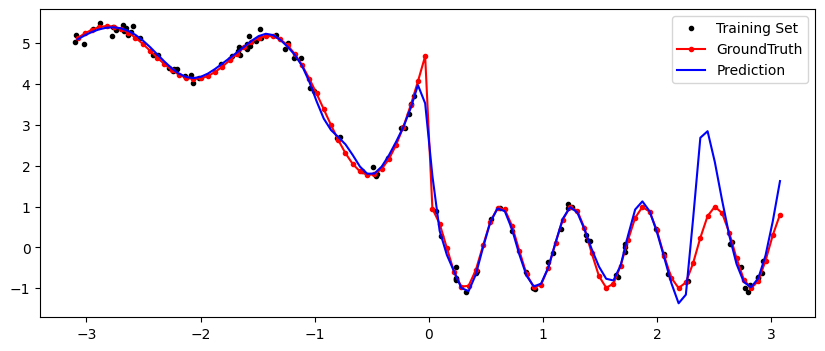

In [7]:
fig = plt.figure(figsize=(10,4))

x_test_torch = torch.from_numpy(x_test).float()
y_test_torch = torch.from_numpy(y_test).float()
y_pred_torch = net(x_test_torch)
y_pred = y_pred_torch.data.numpy()

loss = loss_func(y_test_torch,y_pred_torch)
print('MSE = %5.3f'%(loss.data.numpy()))

plt.plot(x_train,y_train,'k.',label='Training Set')
plt.plot(x_test,y_test,'r.-',label='GroundTruth')
plt.plot(x_test,y_pred,'b-',label='Prediction')
plt.legend()
plt.show()